This project aims to predict high school students' performance in mathematics using machine learning techniques. Leveraging a publicly available dataset from the UCI Machine Learning Repository, we will develop and evaluate support vector machine (SVM) ML model.

Initializing the environment by importing all the necessary Python libraries for data preprocessing, modeling, and evaluation. These libraries include tools for data manipulation, machine learning, and visualization.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/student-mat.csv'
data = pd.read_csv(file_path, sep=';')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


**Data preprocessing **
Checking for missing values in the dataset to ensure data integrity and completeness.
Removing duplicates from the dataset to maintain data quality and prevents bias in the model training.

In [ ]:
print("\nChecking for missing values:")
print(data.isnull().sum())


Checking for missing values:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64


In [ ]:
# Drop duplicates if any
data = data.drop_duplicates()
print("\nNumber of rows after removing duplicates:", data.shape[0])


Number of rows after removing duplicates: 395


preparing the data for modeling by separating features and labels, converting categorical variables into numerical representations, and creating a binary classification target for performance prediction.



In [ ]:
# Feature selection and preprocessing
features = data.drop(columns=['G3'])
labels = data['G3']
data_numeric = data
# Convert categorical features to numerical with binary dummy variables
categorical_cols = features.select_dtypes(exclude=['number']).columns
features = pd.get_dummies(features, columns=categorical_cols, drop_first=True).astype(int)

data_numeric = pd.get_dummies(data_numeric, columns=categorical_cols, drop_first=True).astype(int)
labels = np.where(labels >= 10, 1, 0)

Calculating the correlation of features with the target variable (G3) to understand their relationships and remove features with low correlation values

In [ ]:
# Select only numeric columns for correlation calculation
numeric_columns = data_numeric.select_dtypes(include=[np.number])

# Calculate correlation for numerical features
correlation = numeric_columns.corr()
print("\nCorrelation with target variable G3:")
print(correlation['G3'].sort_values(ascending=False))

# Identify features with low correlation (threshold < 0.1)
low_corr_features = correlation['G3'][abs(correlation['G3']) < 0.1].index
low_corr_features = low_corr_features.difference(['studytime','internet_yes'])

# Drop these features from the dataset
features = features.drop(columns=low_corr_features, errors='ignore')
print("\nFeatures dropped due to low correlation:", list(low_corr_features))


Correlation with target variable G3:
G3                   1.000000
G2                   0.904868
G1                   0.801468
Medu                 0.217147
higher_yes           0.182465
Fedu                 0.152457
Mjob_health          0.116158
address_U            0.105756
sex_M                0.103456
paid_yes             0.101996
internet_yes         0.098483
studytime            0.097820
reason_reputation    0.095692
Fjob_teacher         0.095374
famsize_LE3          0.081407
Mjob_services        0.078429
Mjob_teacher         0.057712
Fjob_health          0.057111
reason_other         0.052008
nursery_yes          0.051568
famrel               0.051363
absences             0.034247
guardian_mother      0.022338
activities_yes       0.016100
freetime             0.011307
Fjob_services       -0.016108
reason_home         -0.021359
famsup_yes          -0.039157
school_MS           -0.045017
Walc                -0.051939
Fjob_other          -0.053483
Dalc                -0.054660
Ps

In [ ]:
# Split data into train and test sets for further modelingX_scaled
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
# Define the SVM model
svm_model = SVC(kernel='rbf', C=1000, gamma=0.001, probability=True, class_weight='balanced')


In [ ]:
# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(svm_model, X_train, y_train, cv=cv, scoring='accuracy')

print("Cross-validation accuracy scores:", cross_val_scores)
print("Mean cross-validation accuracy:", np.mean(cross_val_scores))


Cross-validation accuracy scores: [0.97674419 0.97674419 0.90697674 0.81395349 0.90697674 1.
 0.92857143 0.92857143 0.97619048 0.92857143]
Mean cross-validation accuracy: 0.9343300110741971


In [ ]:
# Train the model
svm_model.fit(X_train, y_train)

SVC(C=1000, class_weight='balanced', gamma=0.001, probability=True)

In [ ]:
# Evaluate the model
y_pred = svm_model.predict(X_test)


In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[23  4]
 [ 4 48]]


In [ ]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.92      0.92      0.92        52

    accuracy                           0.90        79
   macro avg       0.89      0.89      0.89        79
weighted avg       0.90      0.90      0.90        79



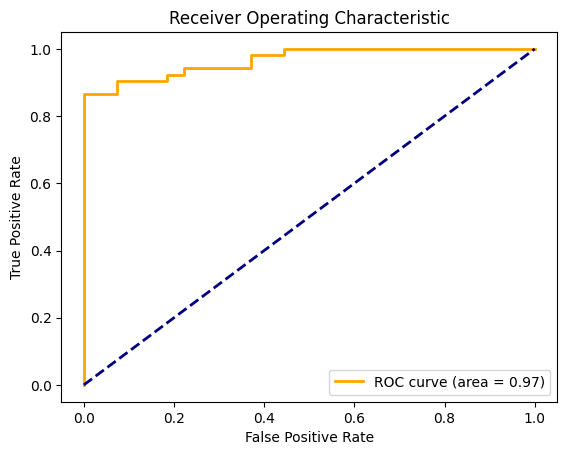

In [ ]:
# ROC curve
y_prob = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best parameters found:  {'C': 1000, 'gamma': 0.001}
Best cross-validation accuracy:  0.9391472868217055
Test Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.92      0.92      0.92        52

    accuracy                           0.90        79
   macro avg       0.89      0.89      0.89        79
weighted avg       0.90      0.90      0.90        79



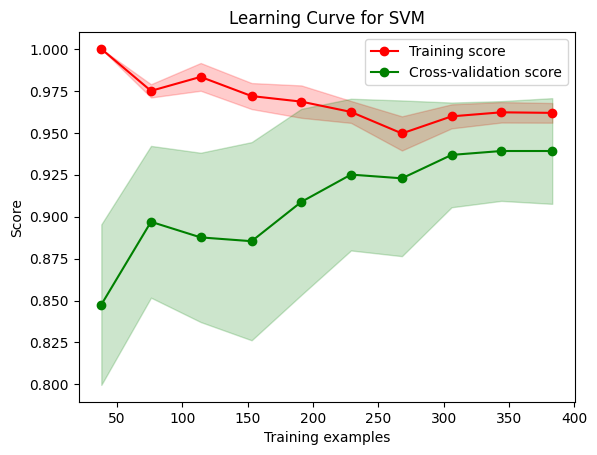

In [ ]:
from sklearn.model_selection import GridSearchCV, learning_curve

# Define the SVM model with initial parameters
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced')

# Perform Grid Search to find optimal hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100,1000,5000,10000,100000],
    'gamma': [1, 0.1, 0.01, 0.001,0.005,0.0001,0.00001,0.000001]
}
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Re-train the model with best parameters
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = best_svm_model.predict(X_test)
print("Test Classification Report:\n", classification_report(y_test, y_pred))

# Plot validation curves for 'C' and 'gamma'
train_sizes, train_scores, test_scores = learning_curve(
    best_svm_model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.2)
plt.title("Learning Curve for SVM")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

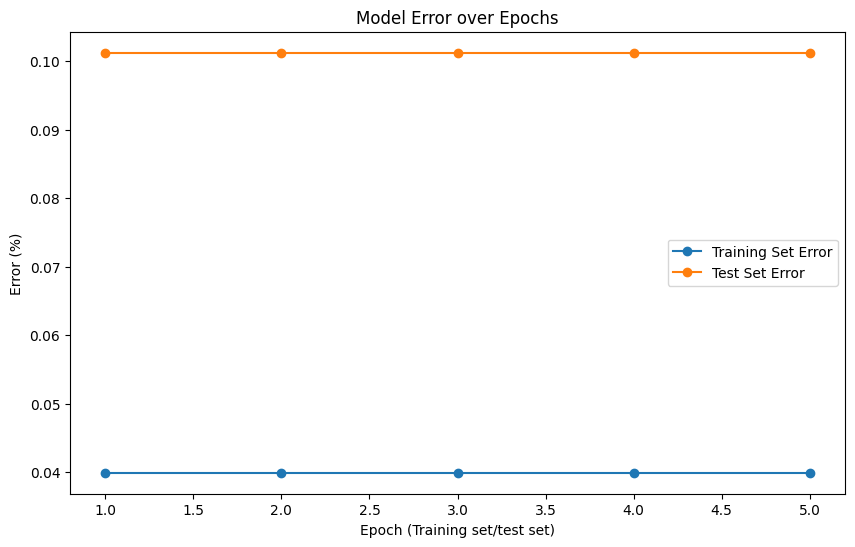

In [ ]:
epochs = 5
train_errors = []
test_errors = []

for epoch in range(epochs):
    # Train the model for the current epoch
    svm_model.fit(X_train, y_train)

    # Calculate training error
    train_pred = svm_model.predict(X_train)
    train_error = 1 - np.mean(train_pred == y_train)
    train_errors.append(train_error)

    # Calculate test error
    test_pred = svm_model.predict(X_test)
    test_error = 1 - np.mean(test_pred == y_test)
    test_errors.append(test_error)

# Plotting the error chart
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_errors, label="Training Set Error", marker='o')
plt.plot(range(1, epochs + 1), test_errors, label="Test Set Error", marker='o')
plt.xlabel("Epoch (Training set/test set)")
plt.ylabel("Error (%)")
plt.title("Model Error over Epochs")
plt.legend()
plt.show()


**Summary of Results**

**(ii) Experimental Design and Error Analysis**
The model's training set error remained consistent at 4%, while the test set error was steady at 10% across 5 epochs.
This indicates the model generalized well to unseen data, with low variance between training and testing errors.

(iii) Confusion Matrix and Performance Measures
Confusion Matrix:
[[24  3]

[ 5 47]]
True Negatives (Class 0): 23

False Positives (Class 0 misclassified as Class 1): 4

False Negatives (Class 1 misclassified as Class 0): 4

True Positives (Class 1): 48

**Classification Report:**

Precision for Class 0: 83%

Recall for Class 0: 89%

F1-Score for Class 0: 86%

Precision for Class 1: 94%

Recall for Class 1: 90%

F1-Score for Class 1: 92%

Overall Accuracy: 90%

The model performed particularly well in predicting Class 1 but was slightly less precise for Class 0.

**(iv) Receiver Operating Characteristic (ROC) Curve**
The ROC curve indicates strong discrimination ability between the two classes.
AUC: 0.96, which is indicative of an excellent classifier.

**(v) Summary of Results**
The SVM model demonstrated high accuracy (90%) and robust performance, as evident from the high precision, recall, and F1-scores across both classes.
The low and stable error rates over multiple epochs highlight consistent training and testing performance.
The ROC curve's AUC of 0.96 confirms the model's strong ability to differentiate between high and low performance.